In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/microsoft-stock-price/MSFT-1.csv


**Importing the necessary libraries**

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB:
    !pip install -q -U tensorflow-addons
    !pip install -q -U transformers

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


**Adding the dataset and the description**

In [3]:
data = pd.read_csv("/kaggle/input/microsoft-stock-price/MSFT-1.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,11/7/2016,59.779999,60.520000,59.779999,60.419998,55.902321,31664800
1,11/8/2016,60.549999,60.779999,60.150002,60.470001,55.948589,22935400
2,11/9/2016,60.000000,60.590000,59.200001,60.169998,55.671009,49632500
3,11/10/2016,60.480000,60.490002,57.630001,58.700001,54.310928,57822400
4,11/11/2016,58.230000,59.119999,58.009998,59.020000,54.607002,38767800


In [4]:
data.drop('Adj Close', axis = 1, inplace = True)

In [5]:
data['Date'] = pd.to_datetime(data.Date,format='%m/%d/%Y')
data.index = data['Date']

In [18]:
data.drop('Date', axis = 1, inplace = True)

In [19]:
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2016-11-07,59.779999,60.520000,59.779999,60.419998,31664800
2016-11-08,60.549999,60.779999,60.150002,60.470001,22935400
2016-11-09,60.000000,60.590000,59.200001,60.169998,49632500
2016-11-10,60.480000,60.490002,57.630001,58.700001,57822400
2016-11-11,58.230000,59.119999,58.009998,59.020000,38767800


**Plotting the closed price against date to observe the trend**

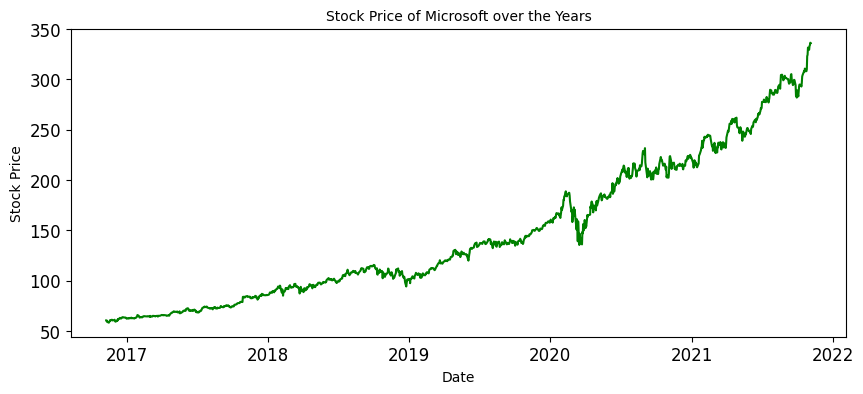

In [15]:
plt.figure(figsize=(10,4))
plt.plot(data['Close'], label='Close Price history',color='g')
plt.xlabel('Date',size=10)
plt.ylabel('Stock Price',size=10)
plt.title('Stock Price of Microsoft over the Years',size=10)
plt.show()

**Split the data into train and validation set**

In [24]:
shape = data.shape[0]
print("Number of datapoints : ", shape)
train_size = int(shape * 0.80)
train, valid = data[0:train_size], data[train_size:shape]
print("training size : ", train.shape)
print("validation size : ", valid.shape)

Number of datapoints :  1259
training size :  (1007, 5)
validation size :  (252, 5)


In [39]:
print(train)

                  Open        High         Low       Close    Volume
Date                                                                
2016-11-07   59.779999   60.520000   59.779999   60.419998  31664800
2016-11-08   60.549999   60.779999   60.150002   60.470001  22935400
2016-11-09   60.000000   60.590000   59.200001   60.169998  49632500
2016-11-10   60.480000   60.490002   57.630001   58.700001  57822400
2016-11-11   58.230000   59.119999   58.009998   59.020000  38767800
...                ...         ...         ...         ...       ...
2020-10-30  203.500000  204.289993  199.619995  202.470001  36953700
2020-11-02  204.289993  205.279999  200.119995  202.330002  30842200
2020-11-03  203.889999  208.119995  203.119995  206.429993  27512000
2020-11-04  214.020004  218.320007  212.419998  216.389999  42311800
2020-11-05  222.039993  224.119995  221.149994  223.289993  36080100

[1007 rows x 5 columns]


**Training the MinMax scaler on train dataset and use it on valid dataset**

In [41]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=train.columns, index = train.index)
valid_scaled = pd.DataFrame(scaler.transform(valid), columns=valid.columns, index = valid.index)

print("Training data after scaling\n")
print(train_scaled.head(2))
print("\nValidation data after scaling\n")
print(valid_scaled.head(2))

Training data after scaling

                Open      High       Low     Close    Volume
Date                                                        
2016-11-07  0.009062  0.008286  0.014700  0.013254  0.233481
2016-11-08  0.013564  0.009782  0.016875  0.013542  0.149396

Validation data after scaling

                Open      High       Low     Close    Volume
Date                                                        
2020-11-06  0.959015  0.951088  0.945199  0.954302  0.171517
2020-11-09  0.971761  0.972724  0.944317  0.923587  0.356103


**Making prediction for Close Price using LSTM**

In [112]:
train_Close = train[['Close']]
valid_Close = valid[['Close']]

In [125]:
scaler_close = MinMaxScaler(feature_range=(0, 1))
train_Close = np.array(scaler_close.fit_transform(data[['Close']]))

In [126]:
print(train_Close)
# print(valid_Close)

[[0.00826387]
 [0.00844353]
 [0.00736562]
 ...
 [0.99123311]
 [1.        ]
 [0.99863465]]


**Taking sequences of length 40 to train the LSTM**

In [127]:
x_train, y_train = [], []
for i in range(40,len(train_Close)):
    x_train.append(train_Close[i-40:i,0])
    y_train.append(train_Close[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [145]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

In [146]:
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
1219/1219 - 21s - loss: 0.0013 - 21s/epoch - 17ms/step
Epoch 2/10
1219/1219 - 19s - loss: 6.0097e-04 - 19s/epoch - 16ms/step
Epoch 3/10
1219/1219 - 18s - loss: 5.0187e-04 - 18s/epoch - 15ms/step
Epoch 4/10
1219/1219 - 19s - loss: 3.6791e-04 - 19s/epoch - 15ms/step
Epoch 5/10
1219/1219 - 19s - loss: 4.0062e-04 - 19s/epoch - 15ms/step
Epoch 6/10
1219/1219 - 19s - loss: 3.0031e-04 - 19s/epoch - 15ms/step
Epoch 7/10
1219/1219 - 19s - loss: 2.7300e-04 - 19s/epoch - 15ms/step
Epoch 8/10
1219/1219 - 18s - loss: 2.4635e-04 - 18s/epoch - 15ms/step
Epoch 9/10
1219/1219 - 19s - loss: 2.6154e-04 - 19s/epoch - 15ms/step
Epoch 10/10
1219/1219 - 18s - loss: 2.1021e-04 - 18s/epoch - 15ms/step


**Preparing the test data to check the prediction accuracy**

we will take the last 40 values and predict based on them

In [147]:
inputs = train_Close[len(train_Close) - len(valid) - 40:]
inputs = inputs.reshape(-1,1)
X_test = []
for i in range(40,inputs.shape[0]):
    X_test.append(inputs[i-40:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

**Predicting the Close price**

In [148]:
closing_price = model.predict(X_test)
closing_price = scaler_close.inverse_transform(closing_price)
rms=np.sqrt(np.mean(np.power((valid_Close - closing_price),2)))
print('RMSE value on validation set:',rms)

8/8 [==============================] - 1s 10ms/step
RMSE value on validation set: 6.079699417899718


/tmp/ipykernel_32/873479282.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_Close['Predictions'] = closing_price


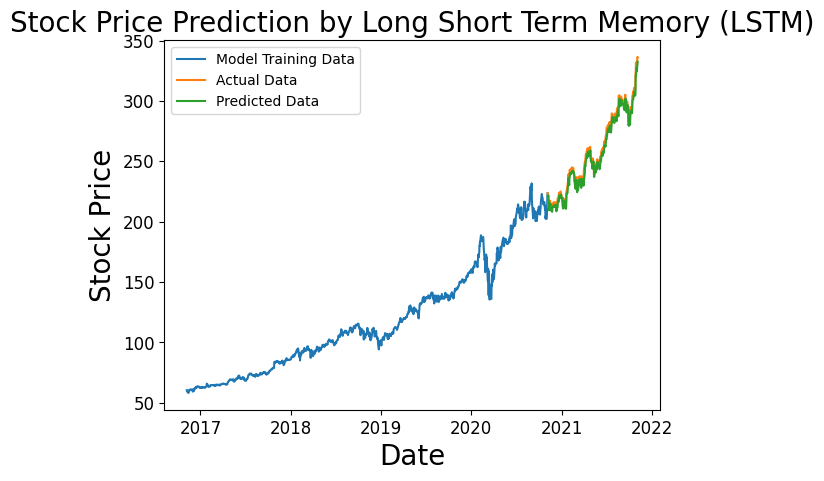

In [149]:
valid_Close['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid_Close[['Close','Predictions']])
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=20)
plt.title('Stock Price Prediction by Long Short Term Memory (LSTM)',size=20)
plt.legend(['Model Training Data','Actual Data','Predicted Data'])

In [150]:
print(valid_Close.head)

<bound method NDFrame.head of                  Close  Predictions
Date                               
2020-11-06  223.720001   220.841278
2020-11-09  218.389999   221.822662
2020-11-10  211.009995   216.704483
2020-11-11  216.550003   209.464752
2020-11-12  215.440002   213.461868
...                ...          ...
2021-11-01  329.369995   327.881866
2021-11-02  333.130005   324.766205
2021-11-03  334.000000   329.123779
2021-11-04  336.440002   330.044037
2021-11-05  336.059998   332.489685

[252 rows x 2 columns]>
